# This notebook is designed for AWS Sagemaker conda_tensorflow_p36 environment

In [1]:
#need to run everytime we reload the instance, this allows skimage to convert to LAB and RGB
!pip install --upgrade scikit-image
!pip install --upgrade numpy

    100% |████████████████████████████████| 26.5MB 1.5MB/s eta 0:00:01
Requirement not upgraded as not directly required: matplotlib!=3.0.0,>=2.0.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (3.0.3)
Requirement not upgraded as not directly required: PyWavelets>=0.4.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (0.5.2)
Requirement not upgraded as not directly required: pillow>=4.3.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (5.2.0)
Requirement not upgraded as not directly required: scipy>=0.19.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (1.3.1)
Requirement not upgraded as not directly required: imageio>=2.3.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (2.3.0)
Requirement not upgraded as not directly required: networkx>=2.0 in

In [2]:
#this enbables tqdm progress bars to show in the notebook
!pip install ipywidgets 
!jupyter nbextension enable --py widgetsnbextension

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
#this installs tqdm progress bars
!pip install tqdm

    100% |████████████████████████████████| 61kB 2.7MB/s ta 0:00:011
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Restart Kernel inbetween installs and imports

In [1]:
import re
import os 
import urllib.request
import numpy as np
import random
import pickle
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, UpSampling2D, Dropout, Flatten, Dense, Input, LeakyReLU, Conv2DTranspose,AveragePooling2D, Concatenate
from keras.models import load_model
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.compat.v1 import set_random_seed
import numpy as np
import matplotlib.pyplot as plt
import pickle
import keras.backend as K
import boto3
import time
from copy import deepcopy


# from sagemaker import get_execution_role
%%time
%matplotlib inline

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [2]:
#import tqdm seperately and use jupyter notebooks %%capture
%%capture
from tqdm import tqdm_notebook as tqdm

In [4]:
#enter your bucket name and use boto3 to identify your region if you don't know it
bucket = None
region = boto3.Session().region_name

'us-east-2'

In [2]:
#add your bucket then creat the containers to download files and send to bucket

role = get_execution_role()

bucket = None # customize to your bucket
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
training_image = containers[boto3.Session().region_name]

CPU times: user 791 ms, sys: 68.9 ms, total: 860 ms
Wall time: 7.27 s


In [4]:

def download(url):
    '''
    Downloads the file of a given url
    '''
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    '''
    Save file in a given folder in the S3 bucket
    '''
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# MPII Human Pose
download('https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz')
upload_to_s3('people', 'mpii_human_pose_v1.tar.gz')

#untar the file
!tar xvzf mpii_human_pose_v1.tar.gz


#MIT coastal 
download('http://cvcl.mit.edu/scenedatabase/coast.zip')
upload_to_s3('coast', 'coast.zip')

#unzip the file
!unzip coast.zip -d ./data


./images/
./images/094426649.jpg
./images/085081267.jpg
./images/059447634.jpg
./images/061509337.jpg
./images/090408171.jpg
./images/056300476.jpg
./images/025224102.jpg
./images/051444643.jpg
./images/079729537.jpg
./images/044684125.jpg
./images/006834837.jpg
./images/071871811.jpg
./images/065755488.jpg
./images/098581511.jpg
./images/033519724.jpg
./images/025542828.jpg
./images/034184904.jpg
./images/036229300.jpg
./images/038371535.jpg
./images/087390724.jpg
./images/095648110.jpg
./images/045299810.jpg
./images/053063558.jpg
./images/060868753.jpg
./images/089470186.jpg
./images/087631943.jpg
./images/025653006.jpg
./images/051807877.jpg
./images/047501676.jpg
./images/048795764.jpg
./images/026598254.jpg
./images/051762983.jpg
./images/076909709.jpg
./images/086261810.jpg
./images/042684141.jpg
./images/003156750.jpg
./images/039559918.jpg
./images/060507149.jpg
./images/066196984.jpg
./images/087833561.jpg
./images/075338542.jpg
./images/062586611.jpg
./images/043949251.jpg
.

./images/017183456.jpg
./images/004905357.jpg
./images/053481816.jpg
./images/007660291.jpg
./images/046332594.jpg
./images/043200459.jpg
./images/013452549.jpg
./images/079514072.jpg
./images/049384701.jpg
./images/021502257.jpg
./images/059684285.jpg
./images/014532669.jpg
./images/077332355.jpg
./images/031291955.jpg
./images/020613892.jpg
./images/049118320.jpg
./images/075731021.jpg
./images/040164518.jpg
./images/039499027.jpg
./images/081923058.jpg
./images/007424686.jpg
./images/092073965.jpg
./images/076977231.jpg
./images/090625458.jpg
./images/020381949.jpg
./images/060709404.jpg
./images/087366866.jpg
./images/045337061.jpg
./images/041078174.jpg
./images/099316374.jpg
./images/090122402.jpg
./images/043657112.jpg
./images/085548595.jpg
./images/025366946.jpg
./images/071652718.jpg
./images/099272462.jpg
./images/065850645.jpg
./images/060673172.jpg
./images/080410925.jpg
./images/097645653.jpg
./images/045688807.jpg
./images/092465111.jpg
./images/051800807.jpg
./images/02

./images/049256907.jpg
./images/044934974.jpg
./images/036645665.jpg
./images/081030330.jpg
./images/009093545.jpg
./images/055250097.jpg
./images/018747933.jpg
./images/059740789.jpg
./images/038279059.jpg
./images/071523685.jpg
./images/018613215.jpg
./images/055417800.jpg
./images/087367711.jpg
./images/041362460.jpg
./images/034558087.jpg
./images/092894674.jpg
./images/005862870.jpg
./images/082541566.jpg
./images/095286952.jpg
./images/045026519.jpg
./images/003218440.jpg
./images/054821591.jpg
./images/045993220.jpg
./images/087154568.jpg
./images/081928504.jpg
./images/099140054.jpg
./images/006903694.jpg
./images/022816733.jpg
./images/029849411.jpg
./images/066407412.jpg
./images/039903532.jpg
./images/016071335.jpg
./images/049104482.jpg
./images/089067860.jpg
./images/017046251.jpg
./images/023442560.jpg
./images/074767177.jpg
./images/026766676.jpg
./images/062112530.jpg
./images/090930415.jpg
./images/007235726.jpg
./images/062007276.jpg
./images/005403959.jpg
./images/04

./images/022807977.jpg
./images/047963196.jpg
./images/055901089.jpg
./images/056391957.jpg
./images/017286052.jpg
./images/015341288.jpg
./images/016427045.jpg
./images/077556815.jpg
./images/057983274.jpg
./images/040432612.jpg
./images/007525760.jpg
./images/049517159.jpg
./images/007890327.jpg
./images/047712977.jpg
./images/003879945.jpg
./images/031200131.jpg
./images/045242689.jpg
./images/048851835.jpg
./images/059678823.jpg
./images/007234851.jpg
./images/039202706.jpg
./images/098102949.jpg
./images/095021121.jpg
./images/042814944.jpg
./images/072113585.jpg
./images/074604488.jpg
./images/037080420.jpg
./images/031228558.jpg
./images/033679279.jpg
./images/014026816.jpg
./images/076949293.jpg
./images/091525188.jpg
./images/082689323.jpg
./images/068915723.jpg
./images/039814928.jpg
./images/083024353.jpg
./images/092606137.jpg
./images/060246917.jpg
./images/010069360.jpg
./images/075549466.jpg
./images/008591039.jpg
./images/046857980.jpg
./images/056666745.jpg
./images/02

./images/071210893.jpg
./images/099456426.jpg
./images/064557218.jpg
./images/009124484.jpg
./images/060787964.jpg
./images/014869932.jpg
./images/054122063.jpg
./images/075342792.jpg
./images/019479380.jpg
./images/080381455.jpg
./images/082635921.jpg
./images/098925624.jpg
./images/021087784.jpg
./images/005267333.jpg
./images/063787283.jpg
./images/001187135.jpg
./images/064879862.jpg
./images/048824113.jpg
./images/082474324.jpg
./images/005530069.jpg
./images/097991443.jpg
./images/078738243.jpg
./images/089064039.jpg
./images/031075661.jpg
./images/095765647.jpg
./images/047430866.jpg
./images/023875177.jpg
./images/049862446.jpg
./images/028814525.jpg
./images/012649096.jpg
./images/066538924.jpg
./images/022297747.jpg
./images/003993219.jpg
./images/017731125.jpg
./images/014679376.jpg
./images/067043433.jpg
./images/078917124.jpg
./images/016988707.jpg
./images/000967254.jpg
./images/077485840.jpg
./images/069464096.jpg
./images/080810566.jpg
./images/091885286.jpg
./images/02

./images/077513282.jpg
./images/094272432.jpg
./images/042586856.jpg
./images/073234907.jpg
./images/022458238.jpg
./images/099080136.jpg
./images/071743445.jpg
./images/064428816.jpg
./images/042988276.jpg
./images/015949063.jpg
./images/075188979.jpg
./images/080795733.jpg
./images/062282924.jpg
./images/074209259.jpg
./images/051093058.jpg
./images/059527684.jpg
./images/037022949.jpg
./images/066353737.jpg
./images/027074467.jpg
./images/064950893.jpg
./images/045272543.jpg
./images/037453615.jpg
./images/065559395.jpg
./images/066097382.jpg
./images/038669254.jpg
./images/007407491.jpg
./images/074180648.jpg
./images/023384837.jpg
./images/062263053.jpg
./images/025466377.jpg
./images/038974418.jpg
./images/041452083.jpg
./images/004457004.jpg
./images/091356256.jpg
./images/006569486.jpg
./images/036913591.jpg
./images/050127564.jpg
./images/017606704.jpg
./images/005307278.jpg
./images/037172407.jpg
./images/066507744.jpg
./images/092701211.jpg
./images/076099076.jpg
./images/02

./images/033808441.jpg
./images/015288712.jpg
./images/087040046.jpg
./images/006443763.jpg
./images/038152769.jpg
./images/096662222.jpg
./images/076252568.jpg
./images/009476847.jpg
./images/090917526.jpg
./images/085148918.jpg
./images/083143562.jpg
./images/021371297.jpg
./images/056553891.jpg
./images/009770297.jpg
./images/041894779.jpg
./images/060585297.jpg
./images/023369004.jpg
./images/081438392.jpg
./images/070274657.jpg
./images/097292571.jpg
./images/012807851.jpg
./images/046020662.jpg
./images/001852458.jpg
./images/068574373.jpg
./images/025903514.jpg
./images/099624210.jpg
./images/002016138.jpg
./images/019127737.jpg
./images/015916753.jpg
./images/007338402.jpg
./images/073222489.jpg
./images/083524555.jpg
./images/004846423.jpg
./images/041667008.jpg
./images/006616872.jpg
./images/027090922.jpg
./images/009929335.jpg
./images/040211739.jpg
./images/023007262.jpg
./images/000992382.jpg
./images/001872471.jpg
./images/004928020.jpg
./images/003834905.jpg
./images/00

Archive:  coast.zip
  inflating: ./data/coast/arnat59.jpg  
  inflating: ./data/coast/art1130.jpg  
  inflating: ./data/coast/art294.jpg  
  inflating: ./data/coast/art487.jpg  
  inflating: ./data/coast/bea1.jpg   
  inflating: ./data/coast/bea10.jpg  
  inflating: ./data/coast/bea14.jpg  
  inflating: ./data/coast/bea2.jpg   
  inflating: ./data/coast/bea20.jpg  
  inflating: ./data/coast/bea24.jpg  
  inflating: ./data/coast/bea26.jpg  
  inflating: ./data/coast/bea27.jpg  
  inflating: ./data/coast/bea29.jpg  
  inflating: ./data/coast/bea3.jpg   
  inflating: ./data/coast/bea30.jpg  
  inflating: ./data/coast/bea33.jpg  
  inflating: ./data/coast/bea38.jpg  
  inflating: ./data/coast/bea39.jpg  
  inflating: ./data/coast/bea4.jpg   
  inflating: ./data/coast/bea5.jpg   
  inflating: ./data/coast/bea9.jpg   
  inflating: ./data/coast/cdmc1000.jpg  
  inflating: ./data/coast/cdmc123.jpg  
  inflating: ./data/coast/cdmc706.jpg  
  inflating: ./data/coast/cdmc821.jpg  
  inflating: ./

  inflating: ./data/coast/nat643.jpg  
  inflating: ./data/coast/nat667.jpg  
  inflating: ./data/coast/nat684.jpg  
  inflating: ./data/coast/nat700.jpg  
  inflating: ./data/coast/nat705.jpg  
  inflating: ./data/coast/nat707.jpg  
  inflating: ./data/coast/nat711.jpg  
  inflating: ./data/coast/nat736.jpg  
  inflating: ./data/coast/nat739.jpg  
  inflating: ./data/coast/nat743.jpg  
  inflating: ./data/coast/nat745.jpg  
  inflating: ./data/coast/nat755.jpg  
  inflating: ./data/coast/nat768.jpg  
  inflating: ./data/coast/nat770.jpg  
  inflating: ./data/coast/nat799.jpg  
  inflating: ./data/coast/nat807.jpg  
  inflating: ./data/coast/nat810.jpg  
  inflating: ./data/coast/nat820.jpg  
  inflating: ./data/coast/nat850.jpg  
  inflating: ./data/coast/nat865.jpg  
  inflating: ./data/coast/nat866.jpg  
  inflating: ./data/coast/nat890.jpg  
  inflating: ./data/coast/nat893.jpg  
  inflating: ./data/coast/nat895.jpg  
  inflating: ./data/coast/nat897.jpg  
  inflating: ./data/coast

# read images from jpg and converts size

In [5]:
def read_img(file, size = (256,256)):
    '''
    reads the images and transforms them to the desired size
    '''
    img = image.load_img(file, target_size=size)
    img = image.img_to_array(img)
    return img

In [6]:
def convert_img_size(file_paths):
    '''
    converts all images to 256x256x3
    '''
    all_images_to_array = np.zeros((len(file_paths), 256, 256, 3), dtype='int64')
    for ind, i in enumerate(file_paths):
        img = read_img(i)
        all_images_to_array[ind] = img.astype('int64')
    print('All Images shape: {} size: {:,}'.format(all_images_to_array.shape, all_images_to_array.size))
    return all_images_to_array

### For people

In [ ]:
file_paths = glob('./images/*.jpg')
X_train = convert_img_size(file_paths)

### For Coast

In [7]:
#obtain filepaths and convert to the correct datatype and size
file_paths = glob('./data/coast/*.jpg')
X_train = np.array([np.array(Image.open(f).getdata()).reshape(256,256,3).astype('uint8') for f in file_paths])

# Converting from RGB to LAB

In [4]:
def rgb_to_lab(img, l=False, ab=False):
    """
    Takes in RGB channels in range 0-255 and outputs L or AB channels in range -1 to 1
    """
    img = img / 255
    l = color.rgb2lab(img)[:,:,0]
    l = l / 50 - 1
    l = l[...,np.newaxis]

    ab = color.rgb2lab(img)[:,:,1:]
    ab = (ab + 128) / 255 * 2 - 1
    if l:
        return l
    else: return ab

def lab_to_rgb(img):
    """
    Takes in LAB channels in range -1 to 1 and out puts RGB chanels in range 0-255
    """
    new_img = np.zeros((256,256,3))
    for i in range(len(img)):
        for j in range(len(img[i])):
            pix = img[i,j]
            new_img[i,j] = [(pix[0] + 1) * 50,(pix[1] +1) / 2 * 255 - 128,(pix[2] +1) / 2 * 255 - 128]
    new_img = color.lab2rgb(new_img) * 255
    new_img = new_img.astype('uint8')
    return new_img

In [17]:
L = np.array([rgb_to_lab(image,l=True)for image in X_train])
AB = np.array([rgb_to_lab(image,ab=True)for image in X_train])

In [29]:
L_AB_channels = (L,AB)

In [30]:
with open('l_ab_channels.p','wb') as f:
        pickle.dump(L_AB_channels,f)

# Loads in LAB channels
If you reloaded the instance you can upload the pickle files here

In [3]:
def load_images(filepath):
    '''
    Loads in pickle files, specifically the L and AB channels
    '''
    with open(filepath, 'rb') as f:
        return pickle.load(f)

In [7]:
X_train_L, X_train_AB = load_images('l_ab_channels.p')

In [10]:
#Run this if you don't want to augment your data, it will be the final X_trains and X_tests

X_test_L = deepcopy(X_train_L[:20])
X_test_AB = deepcopy(X_train_AB[:20])
X_train_L = X_train_L[20:]
X_train_AB = X_train_AB[20:]

## Here is code to augment images
Did not improve my model but might help in other datasets, only run the following 4 cells if you want to add augmented images

In [161]:
# def random_aug(img, theta=random.randint(-20,20),flip_horizontal=bool(random.getrandbits(1)),
#                zx = random.uniform(0.9,1.0), zy = random.uniform(0.9,1.0)):
#     '''
#     Augments the training data for GAN, includes zooms(zx,zy), horizontal flips, and minor rotations(theta)
#     '''
    
#     transform_parameters = { # the required dictionary 
#         'theta':theta, 'zx':zx, 'zy':zy,
#         'flip_horizontal':flip_horizontal}
        
    
#     img_gen = ImageDataGenerator()
#     return img_gen.apply_transform(img, transform_parameters)

In [160]:
#Uncomment if you want to augment your images

# X_train = np.concatenate((X_train_L,X_train_AB),axis=3)
# aug = np.array([lab_to_rgb(image)for image in tqdm(X_train)])

# all_images_to_array = np.zeros((aug.shape[0], 256, 256, 3), dtype='int64')
# for ind,im in tqdm(enumerate(aug)):
#     all_images_to_array[ind] = random_aug(im)
#     X_aug = all_images_to_array
    


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [166]:
# aug_L = np.array([rgb_to_lab(image,l=True)for image in tqdm(X_aug)])
# aug_AB = np.array([rgb_to_lab(image,ab=True)for image in tqdm(X_aug)])

# L = np.vstack((X_train_L,aug_L))
# AB = np.vstack((X_train_AB,aug_AB))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [ ]:
#Run this if you don't want to augment your data, it will be the final X_trains and X_tests

# X_test_L = deepcopy(L[:20])
# X_test_AB = deepcopy(AB[:20])
# X_train_L = L[20:]
# X_train_AB = AB[20:]

# Create the model

In [11]:
d_image_shape = (256,256,2)
g_image_shape = (256,256,1)

In [12]:
def generator():
        '''
        Creates the generator in Keras
        '''
        model = Sequential()
        
        model.add(Conv2D(64,(3,3),padding='same',strides=2, input_shape=g_image_shape)) #dont need pooling since stride=2 downsizes
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #128 x 128
        
        model.add(Conv2D(128, (3,3), padding='same',strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #64 x 64
        
        model.add(Conv2D(256, (3,3),padding='same',strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #32 x 32 
        
        model.add(Conv2D(512,(3,3),padding='same',strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #16 x 16
        
        
        model.add(Conv2DTranspose(256,(3,3), strides=(2,2),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(32,(3,3),strides=(2,2),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv2D(2,(3,3),padding='same'))
        model.add(Activation('tanh'))
        
        l_channel = Input(shape=g_image_shape)
        image = model(l_channel)
        return Model(l_channel,image)

In [13]:
 def discriminator():
        '''
        creates a discriminator in keras
        '''
        model = Sequential()
        model.add(Conv2D(32,(3,3), padding='same',strides=2,input_shape=d_image_shape))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64,(3,3),padding='same',strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(.2))
        model.add(Dropout(0.25))
        
        
        model.add(Conv2D(128,(3,3), padding='same', strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.25))
        
        
        model.add(Conv2D(256,(3,3), padding='same',strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.25))
        
        
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        
        image = Input(shape=d_image_shape)
        validity = model(image)
        return Model(image,validity)

In [14]:
discriminator = discriminator()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(lr=0.00008,beta_1=0.5,beta_2=0.999), 
                    metrics=['accuracy']) 
  
#Making the Discriminator untrainable so that the generator can learn from fixed gradient 
discriminator.trainable = False

# Building the generator 
generator = generator()
  
#Defining the combined model of the Generator and the Discriminator 
l_channel = Input(shape=g_image_shape)
image = generator(l_channel) 
valid = discriminator(image)
  
combined_network = Model(l_channel, valid) 
combined_network.compile(loss='binary_crossentropy', 
                         optimizer=Adam(lr=0.0001,beta_1=0.5,beta_2=0.999))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [15]:
#creates lists to log the losses and accuracy
gen_losses = []
disc_real_losses = []
disc_fake_losses=[] 
disc_acc = []

#train the generator on a full set of 320 and the discriminator on a half set of 160 for each epoch
#discriminator is given real and fake y's while generator is always given real y's
n = 320
y_train_fake = np.zeros([160,1])
y_train_real = np.ones([160,1])
y_gen = np.ones([n,1])

#Optional label smoothing
#y_train_real -= .1


#Pick batch size and number of epochs, number of epochs depends on the number of photos per epoch set above
num_epochs=1500
batch_size=32



/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


160/160 [==============================] - 21s 129ms/step


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
160/160 [==============================] - 7s 47ms/step - loss: 0.3908 - acc: 0.8063
Epoch 1/1
 32/160 [=====>........................] - ETA: 0s - loss: 1.3346 - acc: 0.1562

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


160/160 [==============================] - 1s 4ms/step - loss: 0.5172 - acc: 0.7062
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
 32/160 [=====>........................] - ETA: 0s - loss: 0.5196 - acc: 0.7188

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


160/160 [==============================] - 1s 4ms/step - loss: 0.3339 - acc: 0.8688
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.5065 - acc: 0.7438
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.4415 - acc: 0.7625
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.7831 - acc: 0.5875
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.8186 - acc: 0.6188
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.5690 - acc: 0.7125
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.5776 - acc: 0.7125
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.4302 - acc: 0.8375
Epoch 1/1
160/160 [==============================] - 1s 7ms/ste

160/160 [==============================] - 1s 3ms/step - loss: 0.8408 - acc: 0.5875
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.7373 - acc: 0.6188
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.4846 - acc: 0.7875
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.4867 - acc: 0.7687
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.4016 - acc: 0.8187
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.5864 - acc: 0.6875
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.4913 - acc: 0.7375
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.2647 - acc: 0.918

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 538 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


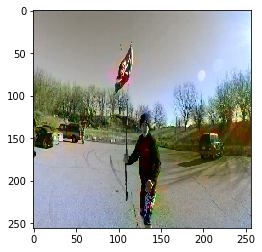

160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.6178 - acc: 0.6688
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.4230 - acc: 0.8000
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.4906 - acc: 0.7375
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.1386 - acc: 0.9938
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.1194 - acc: 0.9813
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.6538 - acc: 0.7375
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.6148 - acc: 0.7062
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.7446 - acc: 0.581

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


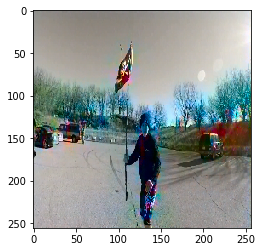

160/160 [==============================] - 1s 8ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.8647 - acc: 0.5563
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.6092 - acc: 0.7125
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.7002 - acc: 0.5938
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.7473 - acc: 0.5938
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.7147 - acc: 0.6500
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.2716 - acc: 0.9125
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.2177 - acc: 0.9375
Epoch 1/1
160/160 [==============================] - 1s 3ms/step - loss: 0.3191 - acc: 0.825

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 129 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


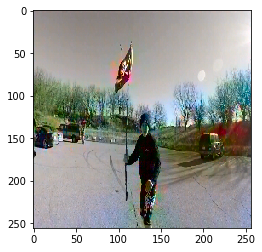

160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.3631 - acc: 0.8250
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.2689 - acc: 0.8750
Epoch 1/1
160/160 [==============================] - 1s 7ms/step
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.3270 - acc: 0.8563
Epoch 1/1
160/160 [==============================] - 1s 4ms/step - loss: 0.7728 - acc: 0.6750
Epoch 1/1
256/320 [=======================>......] - ETA: 1s - loss: 3.7811

In [ ]:
#run and train until photos meet expectations (stop & restart model with tweaks if loss goes to 0 in discriminator)
for epoch in tqdm(range(1,num_epochs+1)):
    #shuffle L and AB channels then take a subset corresponding to each networks training size
    np.random.shuffle(X_train_L)
    l = X_train_L[:n]
    np.random.shuffle(X_train_AB)
    ab = X_train_AB[:160]
    
    fake_images = generator.predict(l[:160], verbose=1)
    
    #Train on Real AB channels
    d_loss_real = discriminator.fit(x=ab, y= y_train_real,batch_size=32,epochs=1,verbose=1) 
    disc_real_losses.append(d_loss_real.history['loss'][-1])
    
    #Train on fake AB channels
    d_loss_fake = discriminator.fit(x=fake_images,y=y_train_fake,batch_size=32,epochs=1,verbose=1)
    disc_fake_losses.append(d_loss_fake.history['loss'][-1])
    
    #append the loss and accuracy and print loss
    disc_acc.append(d_loss_fake.history['acc'][-1])
    

    #Train the gan by producing AB channels from L
    g_loss = combined_network.fit(x=l, y=y_gen,batch_size=32,epochs=1,verbose=1)
    #append and print generator loss
    gen_losses.append(g_loss.history['loss'][-1])
   
    #every 50 epochs it prints a generated photo and every 100 it saves the model under that epoch
    if epoch % 50 == 0:
        print('Reached epoch:',epoch)
        pred = generator.predict(X_test_L[2].reshape(1,256,256,1))
        img = lab_to_rgb(np.dstack((X_test_L[2],pred.reshape(256,256,2))))
        plt.imshow(img)
        plt.show()
        if epoch % 100 == 0:
              generator.save('generator_' + str(epoch)+ '_v3.h5')
        

# After model is trained

#### Print out the losses

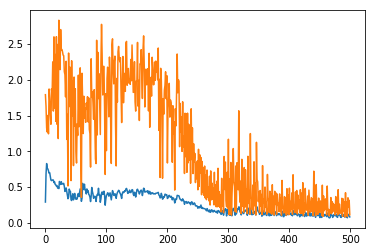

In [37]:
#this is the model with accuracy around 70-90% (epochs are different due to larger training size)
plt.plot(disc_losses)
plt.plot(gen_losses)

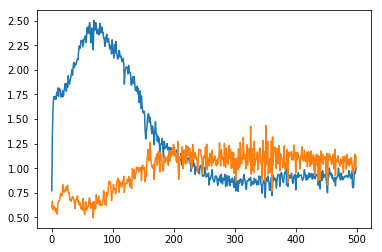

In [18]:
#this is the model with accuracy around 50-60% (epochs are different due to larger training size)
plt.plot(disc_losses)
plt.plot(gen_losses)

In [83]:
#print the generated image
pred = generator.predict(X_test_L[5].reshape(1,256,256,1))
x = lab_to_rgb(np.dstack((X_test_L[5],pred.reshape(256,256,2)))).astype('int64')
plt.imshow(x)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


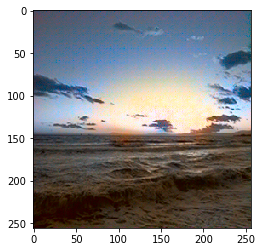

In [23]:
#print the original image
k = lab_to_rgb(np.dstack((X_test_L[5],X_test_AB[5]))).astype('int64')
plt.imshow(k)